Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:/Users/anike/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("C:/Users/anike/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Count:",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Count:",image_count_test)

Train Count: 2239
Test Count: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo

# Define the path to the train directory (adjust the path as needed)
data_dir_train = pathlib.Path(r"C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")

# Use image_dataset_from_directory to load the training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),  # Resize images to target size
    batch_size=batch_size,               # Number of samples per batch
    seed=123,                            # For reproducibility
    validation_split=0.2,                # Reserve 20% of data for validation
    subset="training",                   # Use 80% of data for training
    interpolation='bilinear'             # Interpolation method
)


# Check the dataset structure
print(train_ds)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#val_ds = ##todo

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    image_size=(img_height, img_width),  # Resize images to target size
    batch_size=batch_size,               # Number of samples per batch
    seed=123,                            # For reproducibility
    validation_split=0.2,                # Same validation split
    subset="validation",                 # Use 20% of data for validation
    interpolation='bilinear'             # Interpolation method
)

# Optionally, print a summary of the validation dataset
print(val_ds)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


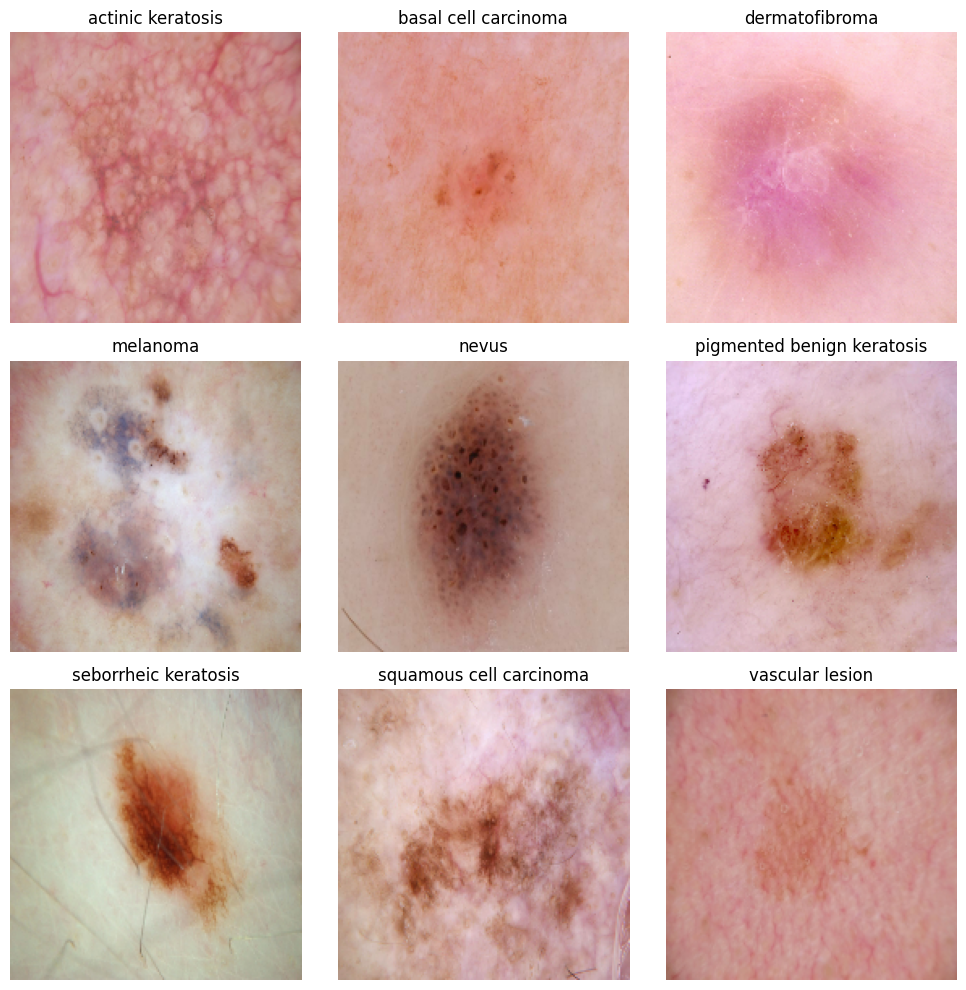

In [9]:
# Get class names
class_names = train_ds.class_names
print("Class names:", class_names)

# Visualize one image from each class
plt.figure(figsize=(10, 10))

# Loop through the class names and display one image from each class
for i, class_name in enumerate(class_names):
    # Get one batch of images and labels
    images, labels = next(iter(train_ds))
    
    # Find an image of the current class
    idx = (labels == i).numpy().argmax()  # Find the first image with the current class
    
    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Set parameters
num_classes = 9   # Number of classes (as per your dataset)

# Define the CNN model
model = models.Sequential([
    # Rescaling the pixel values to [0, 1] (from [0, 255])
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # First Convolutional Layer + Max Pooling
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Layer + Max Pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third Convolutional Layer + Max Pooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the 3D outputs to 1D vector
    layers.Flatten(),
    
    # Fully Connected (Dense) Layer
    layers.Dense(128, activation='relu'),
    
    # Output Layer with 9 neurons (one for each class)
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

c:\Users\anike\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
### Your code goes here
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Loss for integer-labeled data
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.2048 - loss: 2.2381 - val_accuracy: 0.2774 - val_loss: 1.8505
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.3404 - loss: 1.7901 - val_accuracy: 0.4989 - val_loss: 1.5906
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 454ms/step - accuracy: 0.4814 - loss: 1.5269 - val_accuracy: 0.4810 - val_loss: 1.4855
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 462ms/step - accuracy: 0.5044 - loss: 1.4308 - val_accuracy: 0.5078 - val_loss: 1.3912
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 459ms/step - accuracy: 0.5436 - loss: 1.2479 - val_accuracy: 0.5168 - val_loss: 1.3944
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - accuracy: 0.5525 - loss: 1.2769 - val_accuracy: 0.5570 - val_loss: 1.2996
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 259ms/step - accuracy: 0.6307 - loss: 1.0888 - val_accuracy: 0.5414 - val_loss: 1.4310
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - accuracy: 0.5581 - loss: 1.2192 - val_accu

### Visualizing training results

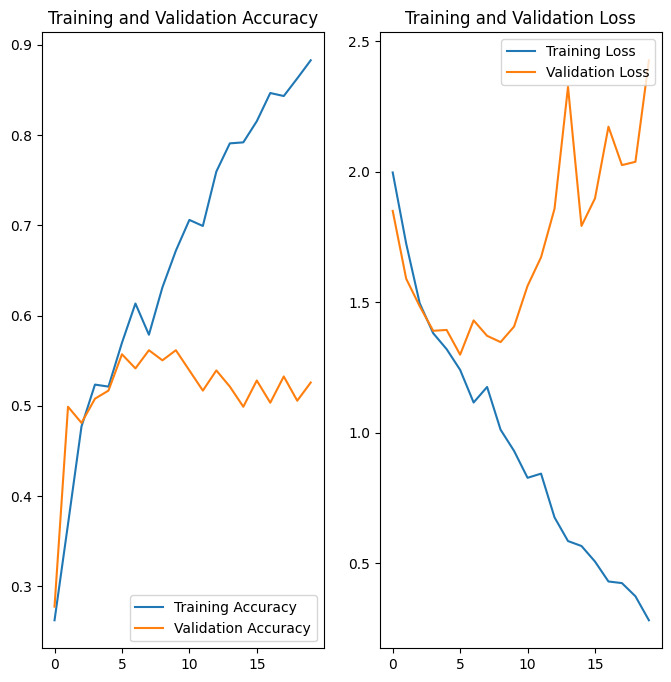

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9254 - loss: 0.2103
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5409 - loss: 2.3678
Accuracy:  0.9291294813156128
Validation Accuracy:  0.5257270932197571
Loss:  0.20348545908927917
Validation Loss 2.427537679672241


In [18]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Step 1: Collect all labels from the training dataset
# all_labels = []
# for images, labels in train_ds:
#     all_labels.extend(labels)  # Directly append labels since it's already a numpy array

# # Step 2: Plot the class distribution directly
# plt.figure(figsize=(10, 6))
# sns.histplot(all_labels, kde=False, bins=len(class_names))  # Histogram of labels

# # Set labels and title
# plt.xlabel('Class Labels')
# plt.ylabel('Number of Samples')
# plt.title('Class Distribution in Training Dataset')

# plt.show()


In [19]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Step 1: Collect all labels from the training dataset
# all_labels = []
# for batch in train_ds:  # `batch` holds both images and labels
#     labels = batch[1]  # Extracting labels directly
#     all_labels += list(labels)


# # Step 2: Count occurrences of each label
# unique_labels, counts = np.unique(all_labels, return_counts=True)

# # Step 3: Plot the bar plot
# plt.figure(figsize=(10, 6))
# sns.barplot(x=unique_labels, y=counts)

# # Set labels and title
# plt.xlabel('Class Labels')
# plt.ylabel('Number of Samples')
# plt.title('Class Distribution in Training Dataset')

# plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings 
- **Training**: Accuracy rises from 22.82% to 82.18%, showing good learning.
- **Validation**: Validation accuracy from 30% to 52% suggests overfitting.
- **Loss**: Training loss decreases, but validation loss fluctuates, indicating overfitting.

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

In [21]:
batch_size = 32
img_height = 180
img_width = 180

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of data for validation
)

# Create an ImageDataGenerator for validation with rescaling only
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Apply the augmentation to the training dataset (80% of the data)
train_ds = train_datagen.flow_from_directory(
    data_dir_train,          # Directory path for images
    target_size=(img_height, img_width),  # Resize images
    batch_size=32,
    class_mode='sparse',     # For sparse categorical crossentropy
    subset='training',       # Use the training subset (80%)
    seed=123,
    interpolation='bilinear'  # Interpolation method
)

# Apply only rescaling to validation data (20% of the data)
val_ds = val_datagen.flow_from_directory(
    data_dir_train,           # Directory path for images
    target_size=(img_height, img_width),  # Resize images
    batch_size=32,
    class_mode='sparse',      # For sparse categorical crossentropy
    subset='validation',     # Use the validation subset (20%)
    seed=123,
    interpolation='bilinear'  # Interpolation method
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [23]:
# Accessing class names from train_ds
class_names = train_ds.class_indices
print("Class Names:", class_names)

Class Names: {'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6, 'squamous cell carcinoma': 7, 'vascular lesion': 8}


In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Get a batch of images and their labels from the training dataset


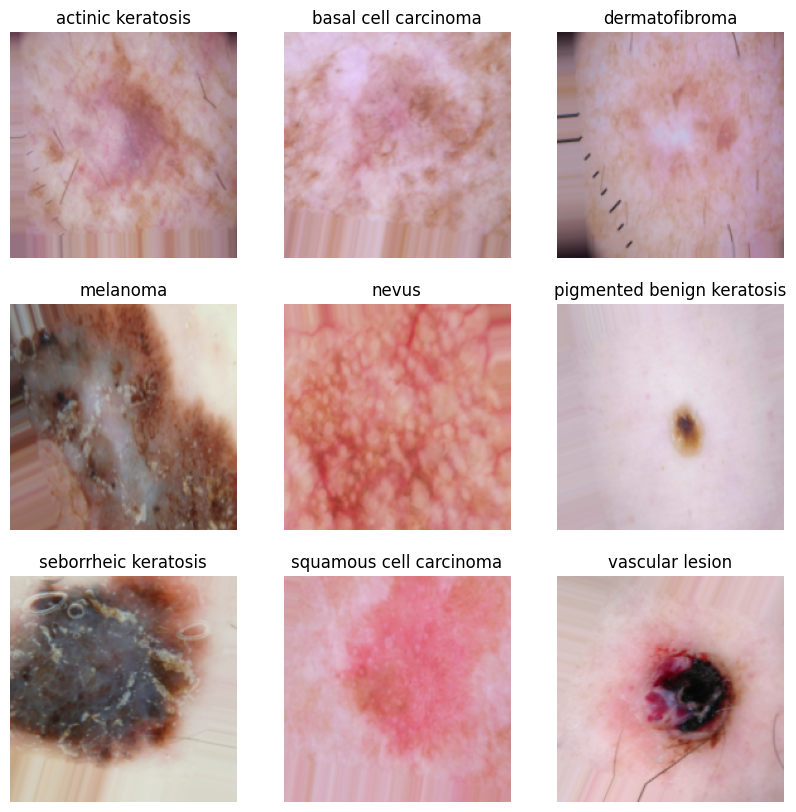

In [25]:
import matplotlib.pyplot as plt

# Store one image per class
class_images = [None] * 9  # Assuming 9 classes in total

# Fetch class names from train_ds using class_indices
class_names = list(train_ds.class_indices.keys())

# Loop through the dataset to collect one image per class
for images, labels in train_ds:
    for i, label in enumerate(labels):
        label = int(label)  # Ensure the label is an integer
        if class_images[label] is None:  # If class hasn't been collected yet
            class_images[label] = images[i]  # Save one image for that class
    
    # Stop once all classes have at least one image
    if all(image is not None for image in class_images):
        break

# Plot one image per class
plt.figure(figsize=(10, 10))
for i, image in enumerate(class_images):
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{class_names[i]}")  # Display the actual class name
plt.show()


In [26]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

c:\Users\anike\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 458ms/step - accuracy: 0.1854 - loss: 77.6704
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.1893 - loss: 79.1210
Accuracy:  0.19554316997528076
Validation Accuracy:  0.19594594836235046
Loss:  76.6175308227539
Validation Loss 76.53470611572266


### Todo:
### Create the model, compile and train the model

In [27]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

# import tensorflow as tf
# from tensorflow.keras import layers, models

# # Define the model
# model = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),  # Dropout for regularization
#     layers.Dense(num_classes, activation='softmax')  # Change 'num_classes' to the number of output classes
# ])



In [28]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Fourth Convolutional Block (New Layer)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Fifth Convolutional Block (New Layer)
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Sixth Convolutional Block (New Layer)
    layers.Conv2D(1024, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Increased units
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])


c:\Users\anike\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [29]:
## Your code goes here
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 5, 5, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,390,473 (32.01 MB)

 Trainable params: 8,390,473 (32.01 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [30]:
## Your code goes here, note: train your model for 20 epochs
#history = ## your training code
# Train the model

history = model.fit(
    train_ds,
    epochs=20,  # You can run for more epochs
    validation_data=val_ds,
    verbose=1,
)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 904ms/step - accuracy: 0.1936 - loss: 2.0840 - val_accuracy: 0.2072 - val_loss: 2.0137
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 871ms/step - accuracy: 0.1848 - loss: 2.0212 - val_accuracy: 0.2455 - val_loss: 1.9742
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 48s 841ms/step - accuracy: 0.2462 - loss: 1.9639 - val_accuracy: 0.2725 - val_loss: 1.8469
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 869ms/step - accuracy: 0.2688 - loss: 1.9150 - val_accuracy: 0.2680 - val_loss: 1.7731
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 927ms/step - accuracy: 0.3468 - loss: 1.7669 - val_accuracy: 0.3198 - val_loss: 1.7008
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3654 - loss: 1.7016 - val_accuracy: 0.3288 - val_loss: 1.9007
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3943 - loss: 1.6634 - val_accuracy: 0.3851 - val_loss: 1.7843
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 877ms/step - accuracy: 0.4234 - loss: 1.5799 - val_accuracy: 

### Visualizing the results

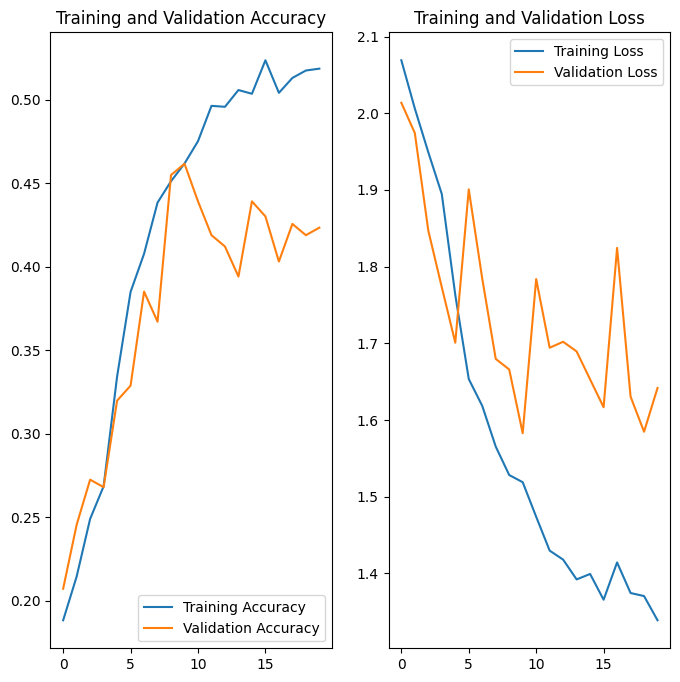

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [91]:
path_to_training_dataset=pathlib.Path("C:/Users/anike/Downloads/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1DD52F4CF10>: 100%|██████████| 500/500 [00:01<00:00, 277.39 Samples/s]


Initialised with 376 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DD53B9F510>: 100%|██████████| 500/500 [00:01<00:00, 309.03 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DD52E72BD0>: 100%|██████████| 500/500 [00:01<00:00, 315.89 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1DD53AA3290>: 100%|██████████| 500/500 [00:08<00:00, 60.72 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x1DD44B7E650>: 100%|██████████| 500/500 [00:07<00:00, 68.43 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1DD53B72010>: 100%|██████████| 500/500 [00:01<00:00, 294.01 Samples/s]


Initialised with 77 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1DD53A60D10>: 100%|██████████| 500/500 [00:03<00:00, 136.30 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DD52D64410>: 100%|██████████| 500/500 [00:01<00:00, 303.71 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1DD53B29B10>: 100%|██████████| 500/500 [00:01<00:00, 280.46 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [92]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [93]:
import  glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['C:\\Users\\anike\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6a6803a9-cdab-4e8b-bf4b-fe2c7a888134.jpg',
 'C:\\Users\\anike\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_83629e77-2fe7-426e-8ec2-a293461c7cd8.jpg',
 'C:\\Users\\anike\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_93c8811d-e356-48a5-b801-e39340c39929.jpg',
 'C:\\Users\\anike\\Downloads\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ca811cbf-6a7a-4210-b6d5-4b0f57eb81b4.jpg',
 'C:\\Users\\anike\\Downloads\\CNN_assignment\\Skin cancer ISIC The Internat

In [94]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [95]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [96]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [97]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [99]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [100]:
data_dir_train = pathlib.Path(r"C:\Users\anike\Downloads\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [101]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization,Dropout

input_shape = (180,180,3)

## your code goes here
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

c:\Users\anike\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 43, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     7,225,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,366,433 (28.10 MB)

 Trainable params: 7,365,729 (28.10 MB)

 Non-trainable params: 704 (2.75 KB)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [109]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [110]:
epochs = 30
# Example compile step
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Now fit the model
history = model.fit(train_ds,
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=val_ds, 
                    callbacks=[learning_rate_reduction])


Epoch 1/30


c:\Users\anike\anaconda3\Lib\site-packages\keras\src\ops\nn.py:827: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\anike\anaconda3\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 126s 729ms/step - accuracy: 0.1378 - loss: 0.0000e+00 - val_accuracy: 0.1151 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 132s 782ms/step - accuracy: 0.1366 - loss: 0.0000e+00 - val_accuracy: 0.1151 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 124s 736ms/step - accuracy: 0.1381 - loss: 0.0000e+00 - val_accuracy: 0.1151 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.1369 - loss: 0.0000e+00
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 ━━━━━━━━━━━━━━━━━━━━ 130s 768ms/step - accuracy: 0.1369 - loss: 0.0000e+00 - val_accuracy: 0.1151 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 147s 872ms/step - accuracy: 0.1344 - loss: 0.0000e+00 - val_accuracy: 0.1151 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 6/30
169/169 ━━━━━━━━━━━

#### **Todo:**  Visualize the model results

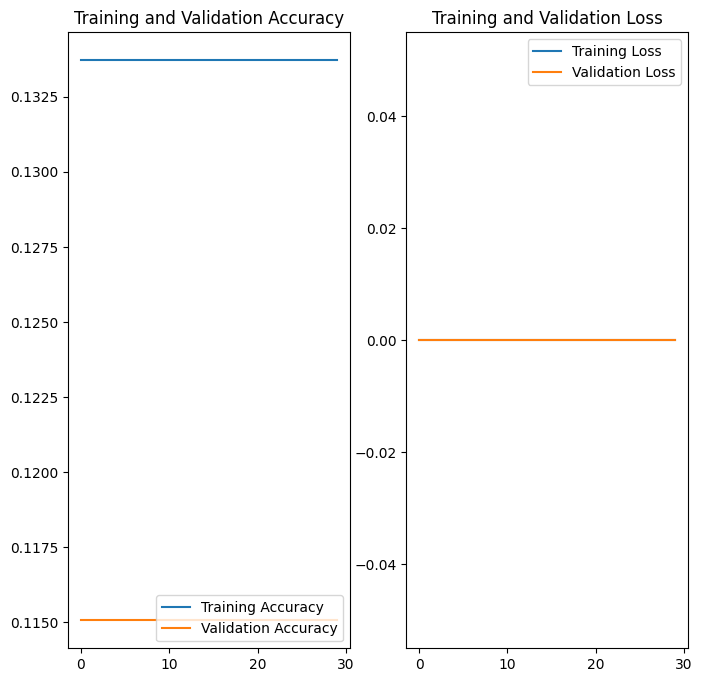

In [111]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Without the ImageDataGenerator model gets to overfit at higher ratio

Rebalance class is reducing overfititng of the data and thus the loss is beng reduced, but it reduced the Acurracy as well

By using dropout and ImageDataGenerator we tried to reduce the overfiting

After that we try to use Batch Normalization with Augumentation to get the outputs.